# 中尺度模式预报对比分析

- 分析中尺度模式的预报产品
- 绘制相关的诊断分析图形产品

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from nmc_met_io.retrieve_micaps_server import get_model_grid
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy
from nmc_met_graphics.plot.util import add_logo, add_model_title, get_model_time_stamp
from nmc_met_map.utility import model_filename
from metpy.plots import colortables

In [9]:
cref = get_model_grid('SHANGHAI_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE', filename='19052908.012')

In [10]:
cref

<xarray.DataArray 'data' (time: 1, lat: 528, lon: 1044)>
array([[[9999., 9999., ..., 9999., 9999.],
        [9999., 9999., ..., 9999., 9999.],
        ...,
        [9999., 9999., ..., 9999., 9999.],
        [9999., 9999., ..., 9999., 9999.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2019-05-29T20:00:00
  * lat        (lat) float64 7.3 7.4 7.5 7.6 7.7 ... 59.6 59.7 59.8 59.9 60.0
  * lon        (lon) float64 52.8 52.9 53.0 53.1 ... 156.8 156.9 157.0 157.1
    init_time  (time) datetime64[ns] 2019-05-29T08:00:00
    fhour      (time) float64 12.0
Attributes:
    data_directory:  SHANGHAI_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE
    data_filename:   19052908.012
    organization:    Created by NMC.

In [6]:
# load micaps dat
filename = '19051908.012'
cref = get_model_grid('SHANGHAI_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE', filename=filename)
uwind = get_model_grid('SHANGHAI_MR/UGRD/850', filename=filename)
vwind = get_model_grid('SHANGHAI_MR/VGRD/850', filename=filename)

In [4]:
data = np.ma.masked_array(cref.values)
data[data == 9999] = np.ma.masked
data[data < 10] = np.ma.masked

In [14]:
data.shape

(1, 528, 1044)

In [5]:
cref_data = {'lon':cref.coords['lon'].values, 'lat':cref.coords['lat'].values, 'data':np.squeeze(data)}
uwind_data = {'lon':uwind.coords['lon'].values, 'lat':uwind.coords['lat'].values, 'data':np.squeeze(uwind.values)}
vwind_data = {'lon':vwind.coords['lon'].values, 'lat':vwind.coords['lat'].values, 'data':np.squeeze(vwind.values)}

In [18]:
norm

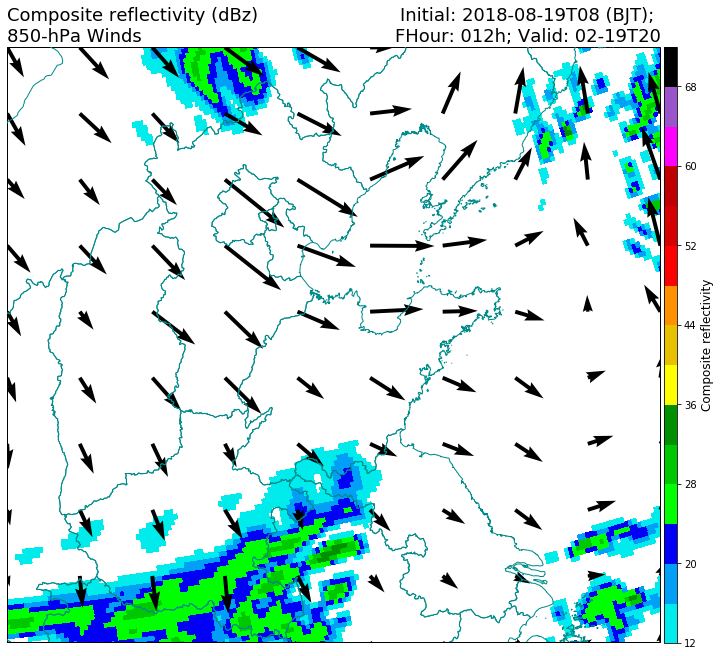

In [19]:
# make weather map

# set data adn plot projection
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.AlbersEqualArea(central_latitude=45., central_longitude=100., standard_parallels=[30., 60.])

# set figure
fig = plt.figure(figsize=(12, 9))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, .02], bottom=.07, top=.99, hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# plot backgroud
ax.set_extent([110, 125, 32, 42], crs=datacrs)
add_china_map_2cartopy(ax, name='province', edgecolor='darkcyan', lw=1, zorder=100)

# add title
plt.title('Composite reflectivity (dBz)\n850-hPa Winds',loc='left', fontsize=18)
plt.title('Initial: 2018-08-19T08 (BJT); \nFHour: 012h; Valid: 02-19T20', loc='right', fontsize=18)

# draw composite reflectivity
x, y = np.meshgrid(cref_data['lon'], cref_data['lat'])
norm, cmap = colortables.get_with_steps('NWSReflectivity', 12, 4)
pm = ax.pcolormesh(x, y, cref_data['data'], norm=norm, cmap=cmap, transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(pm, cax=cax, orientation='vertical', extendrect='True')
cb.set_label('Composite reflectivity', size=12)

# draw wind vector
x, y = np.meshgrid(uwind_data['lon'], uwind_data['lat'])
ax.quiver(x, y, uwind_data['data'], vwind_data['data'], transform=datacrs, regrid_shape=10)

In [48]:
def cref_uv850(initial_time, fhour=0, model='ShangHai',
               map_center=(117, 39), map_width=12, draw_wind=False):
    """
    Analysis composite reflectivity and 850hPa wind.
    
    """
    
    # micaps data directory
    data_dirs = {'SHANGHAI':['SHANGHAI_HR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                             'SHANGHAI_HR/UGRD/850', 'SHANGHAI_HR/VGRD/850'],
                 'BEIJING':['BEIJING_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                            'BEIJING_MR/UGRD/850', 'BEIJING_MR/VGRD/850'],
                 'GRAPES_MESO':['GRAPES_MESO_HR/RADAR_COMBINATION_REFLECTIVITY',
                                'GRAPES_MESO_HR/UGRD/850', 'GRAPES_MESO_HR/VGRD/850'],
                 'GRAPES_3KM':['GRAPES_3KM/RADAR_COMBINATION_REFLECTIVITY',
                               'GRAPES_3KM/UGRD/850', 'GRAPES_3KM/VGRD/850']}
    try:
        data_dir = data_dirs[model.strip().upper()]
    except KeyError:
        raise ValueError('Unknown model, choose ShangHai, BeiJing or Grapes_meso.')
        
    # get filename
    filename = model_filename(initial_time, fhour)
    
    # retrieve data from micaps server
    cref = get_model_grid(data_dir[0], filename=filename)
    if cref is None:
        return
    init_time = cref.coords['init_time'].values[0]
    if draw_wind:
        u850 = get_model_grid(data_dir[1], filename=filename)
        if u850 is None:
            return
        v850 = get_model_grid(data_dir[2], filename=filename)
        if v850 is None:
            return
    
    # prepare data
    data = np.ma.masked_array(cref.values)
    data[data == 9999] = np.ma.masked
    data[data < 10] = np.ma.masked
    cref_data = {'lon':cref.coords['lon'].values, 
                 'lat':cref.coords['lat'].values, 
                 'data':np.squeeze(data)}
    if draw_wind:
        uv850 = {'lon': u850.coords['lon'].values,
                 'lat': u850.coords['lat'].values,
                 'udata': np.squeeze(u850.values),
                 'vdata': np.squeeze(v850.values)}
    
    # set up map projection
    datacrs = ccrs.PlateCarree()
    plotcrs = ccrs.AlbersEqualArea(
        central_latitude=map_center[1], central_longitude=map_center[0],
        standard_parallels=[30., 60.])
    
    # set up figure
    fig = plt.figure(figsize=(12, 9))
    gs = mpl.gridspec.GridSpec(
        1, 2, width_ratios=[1, .03], 
        bottom=.01, top=.99, hspace=0.01, wspace=0.01)
    ax = plt.subplot(gs[0], projection=plotcrs)
    
    # add model title
    add_model_title(
        'CREF (dBz), 850-hPa Winds', init_time, model=model,
        fhour=fhour, fontsize=18, multilines=True)
    
    # add map background
    map_extent = (
        map_center[0] - map_width/2.0, map_center[0] + map_width/2.0,
        map_center[1] - map_width/3.0, map_center[1] + map_width/3.0)
    ax.set_extent(map_extent, crs=datacrs)
    add_china_map_2cartopy(
        ax, name='province', edgecolor='black',
        lw=2, zorder=100)
    
    # draw composite reflectivity
    x, y = np.meshgrid(cref_data['lon'], cref_data['lat'])
    norm, cmap = colortables.get_with_steps('NWSReflectivity', 12, 4)
    pm = ax.pcolormesh(x, y, cref_data['data'], norm=norm, cmap=cmap, transform=datacrs)
    cax = plt.subplot(gs[1])
    cb = plt.colorbar(pm, cax=cax, orientation='vertical', extendrect='True')
    cb.set_label('Composite reflectivity', size=12)

    # draw wind vector
    if draw_wind:
        x, y = np.meshgrid(uv850['lon'], uv850['lat'])
        ax.quiver(x, y, uv850['udata'], uv850['vdata'],
                  transform=datacrs, regrid_shape=25)
    
    # show figure
    gs.tight_layout(fig)
    plt.show()

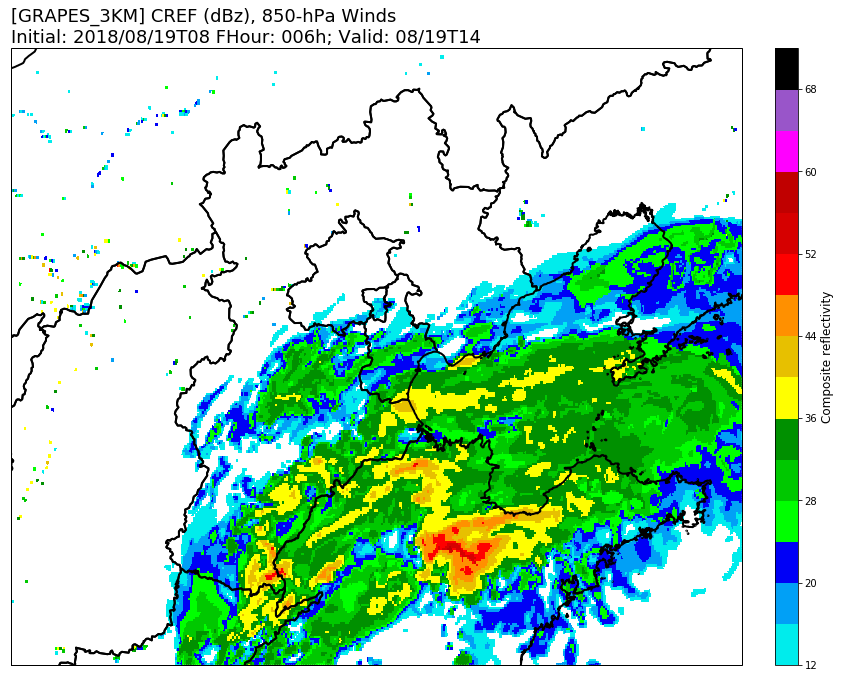

In [49]:
cref_uv850('18081908', fhour=6, model='GRAPES_3KM')

In [105]:
def add_titlebox(ax, text):
    ax.text(.05, .9, text,
        horizontalalignment='left',
        transform=ax.transAxes,
        bbox=dict(facecolor='white'),
        fontsize=12.5)
    return ax

def cref_uv850_compare(initial_time, fhour=0, map_center=(117, 39), map_width=12, draw_wind=False):
    """
    Analysis composite reflectivity and 850hPa wind.
    
    """
    
    # micaps data directory
    data_dirs = {'SHANGHAI':['SHANGHAI_HR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                             'SHANGHAI_HR/UGRD/850', 'SHANGHAI_HR/VGRD/850'],
                 'BEIJING':['BEIJING_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                            'BEIJING_MR/UGRD/850', 'BEIJING_MR/VGRD/850'],
                 'GRAPES_MESO':['GRAPES_MESO_HR/RADAR_COMBINATION_REFLECTIVITY',
                                'GRAPES_MESO_HR/UGRD/850', 'GRAPES_MESO_HR/VGRD/850'],
                 'GRAPES_3KM':['GRAPES_3KM/RADAR_COMBINATION_REFLECTIVITY',
                               'GRAPES_3KM/UGRD/850', 'GRAPES_3KM/VGRD/850']}
    
    # get filename
    filename = model_filename(initial_time, fhour)
    
    # set up map projection
    datacrs = ccrs.PlateCarree()
    plotcrs = ccrs.AlbersEqualArea(
        central_latitude=map_center[1], central_longitude=map_center[0],
        standard_parallels=[30., 60.])
    
    # set up figure
    fig = plt.figure(figsize=(16, 12))
    axes_class = (GeoAxes, dict(map_projection=plotcrs))
    grid = AxesGrid(fig, 111, axes_class=axes_class, nrows_ncols=(2, 2), axes_pad=0.05,
                    cbar_location='right', cbar_mode='single', cbar_pad=0.05, label_mode='')
    
    # loop every data directory
    for index, key in enumerate(data_dirs):
        # get axis and data directory
        ax = grid[index]
        data_dir = data_dirs[key]
        
        # retrieve data from micaps server
        cref = get_model_grid(data_dir[0], filename=filename)
        if cref is None:
            return
        init_time = cref.coords['init_time'].values[0]
        if draw_wind:
            u850 = get_model_grid(data_dir[1], filename=filename)
            if u850 is None:
                return
            v850 = get_model_grid(data_dir[2], filename=filename)
            if v850 is None:
                return
            
        # add title
        if index == 0:
            initial_str, fhour_str, valid_str = get_model_time_stamp(init_time, fhour)
            fig.suptitle('CREF (dBz), 850-hPa Winds    ' + initial_str + '; ' + fhour_str + '; ' + valid_str,
                         x=0.5, y=0.9, fontsize=16)
    
        # prepare data
        data = np.ma.masked_array(cref.values)
        data[data == 9999] = np.ma.masked
        data[data < 10] = np.ma.masked
        cref_data = {'lon':cref.coords['lon'].values, 
                     'lat':cref.coords['lat'].values, 
                     'data':np.squeeze(data)}
        if draw_wind:
            uv850 = {'lon': u850.coords['lon'].values,
                     'lat': u850.coords['lat'].values,
                     'udata': np.squeeze(u850.values),
                     'vdata': np.squeeze(v850.values)}
    
        # add map background
        map_extent = (
            map_center[0] - map_width/2.0, map_center[0] + map_width/2.0,
            map_center[1] - map_width/3.0, map_center[1] + map_width/3.0)
        ax.set_extent(map_extent, crs=datacrs)
        add_china_map_2cartopy(
            ax, name='province', edgecolor='black',
            lw=2, zorder=100)
    
        # draw composite reflectivity
        x, y = np.meshgrid(cref_data['lon'], cref_data['lat'])
        norm, cmap = colortables.get_with_steps('NWSReflectivity', 12, 4)
        pm = ax.pcolormesh(x, y, cref_data['data'], norm=norm, cmap=cmap, transform=datacrs)

        # draw wind vector
        if draw_wind:
            x, y = np.meshgrid(uv850['lon'], uv850['lat'])
            ax.quiver(x, y, uv850['udata'], uv850['vdata'],
                      transform=datacrs, regrid_shape=25)
            
        # add title
        add_titlebox(ax, key)
            
    # add color bar
    cbar = grid.cbar_axes[0].colorbar(pm)
    
    # show figure
    plt.show()

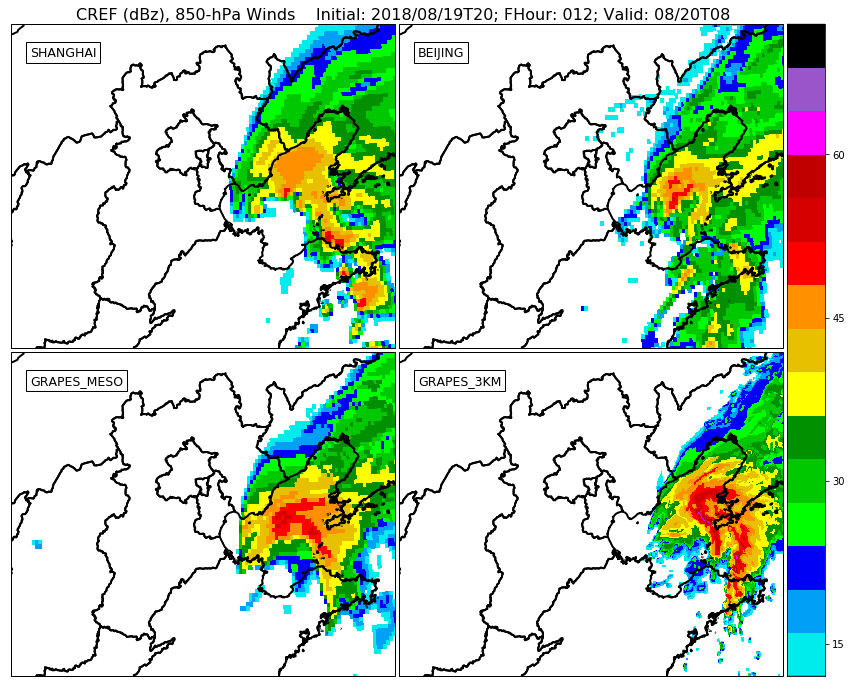

In [106]:
cref_uv850_compare('18081920', fhour=12)

In [51]:
data_dirs = {'SHANGHAI':['SHANGHAI_HR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                             'SHANGHAI_HR/UGRD/850', 'SHANGHAI_HR/VGRD/850'],
                 'BEIJING':['BEIJING_MR/COMPOSITE_REFLECTIVITY/ENTIRE_ATMOSPHERE',
                            'BEIJING_MR/UGRD/850', 'BEIJING_MR/VGRD/850'],
                 'GRAPES_MESO':['GRAPES_MESO_HR/RADAR_COMBINATION_REFLECTIVITY',
                                'GRAPES_MESO_HR/UGRD/850', 'GRAPES_MESO_HR/VGRD/850'],
                 'GRAPES_3KM':['GRAPES_3KM/RADAR_COMBINATION_REFLECTIVITY',
                               'GRAPES_3KM/UGRD/850', 'GRAPES_3KM/VGRD/850']}